In [6]:
%matplotlib inline
from collections import defaultdict

# Settings

In [2]:
PCT_TEST_SPLIT = 0.2
SPLITS = 500000

#Source Folder (essay_folder) - CHANGE THIS ONE SETTING TO SWITCH BETWEEN CB AND SC!!!!!

essay_folder = "CoralBleaching/BrattData/EBA1415_Merged/"
#essay_folder = "SkinCancer/EBA1415_Merged/"



data_dir = "/Users/simon.hughes/Google Drive/Phd/Data/"
folder = data_dir + essay_folder

root_folder = data_dir + essay_folder.split("/")[0] + "/Thesis_Dataset/"
print("Root: " + root_folder)

all_folder      = root_folder + "All_Files/"
test_folder     = root_folder + "Test/"
training_folder = root_folder + "Training/"

print("")
for f in [all_folder, training_folder, test_folder]:
    print(f)

Root: /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/Thesis_Dataset/

/Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/Thesis_Dataset/All_Files/
/Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/Thesis_Dataset/Training/
/Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/Thesis_Dataset/Test/


# Map .ann And .txt Files

In [3]:
import os, re

def find_files(folder, regex, remove_empty = False):
    """
    Find all files matching the [regex] pattern in [folder]

    folder  :   string
                    folder to search (not recursive)
    regex   :   string (NOT regex object)
                    pattern to match
    """
    files = os.listdir(folder)
    matches = [os.path.abspath(os.path.join(folder, f))
               for f in files
               if re.search(regex, f, re.IGNORECASE)]

    if remove_empty:
        matches = [f for f in matches if os.path.getsize(f) > 0]
    matches.sort()
    return matches

In [4]:
ann_files = find_files(folder, "\.ann$", remove_empty=True)
txt_files = find_files(folder, "\.txt$", remove_empty=True)
len(ann_files), len(txt_files)

(1154, 1161)

In [7]:
def get_prefix(fname):
    return fname[:-4]

dct_ann = defaultdict(set)
for ann in ann_files:
    prefix = get_prefix(ann)
    dct_ann[prefix].add(ann)

dct_txt = defaultdict(set)
for txt in txt_files:
    prefix = get_prefix(txt)
    dct_txt[prefix].add(txt)

len(dct_ann), len(dct_txt)

(1154, 1161)

### Joined Represents a Mapping Between Prefixes and (.ann,.txt) Filenames

In [10]:
joined = {}
for prfx in dct_ann.keys():
    if prfx in dct_txt:
        joined[prfx] = (dct_ann[prfx], dct_txt[prfx])
len(joined)

1154

# Load and Parse Actual The Essay Files (Removing Invalid and Empty Files)

In [9]:
%%time
from BrattEssay import load_bratt_essays
from collections import defaultdict
from IterableFP import flatten
from Settings import Settings
settings = Settings()
essays = load_bratt_essays(folder)

Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/simon.hughes/GitHub/NlpResearch/
Public Data: /Users/simon.hughes/GitHub/NlpResearch/Data/PublicDatasets/
1154 files found
Skipping /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/BrattData/EBA1415_Merged/EBA1415_AEKD_4_CB_ES-05571.ann file as .txt file is no essay'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/BrattData/EBA1415_Merged/EBA1415_AEKD_4_CB_ES-05904.ann file as .txt file is no essay'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/BrattData/EBA1415_Merged/EBA1415_BGJD_1_CB_ES-05733.ann file as .txt file is no essay //'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/BrattData/EBA1415_Merged/EBA1415_ERSK_7_CB_ES-05798.ann file as .txt file is no essay //'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/CoralBleaching/BrattData/EBA1415_Merged/EBA1415_KYLS_5_CB_ES-05671.ann fi

### Now Remove Invalid Files from the Joined List

In [11]:
valid_essays = set(map(lambda essay: get_prefix(essay.full_path), essays))
match = set((e for e in valid_essays if e in joined))
len(valid_essays), len(match), len(joined)

(1128, 1128, 1154)

In [13]:
deleted = 0
for e in list(joined.keys()):
    if e not in match:
        del joined[e]
        deleted+=1
print(deleted, "Essays deleted")
print(len(valid_essays), len(match), len(joined))

26 Essays deleted
1128 1128 1128


# Partition into Train and Test Sets

## 1. Calculate the Partition Sizes (in ints):

In [15]:
num = len(joined.keys())
n_test = int(round(PCT_TEST_SPLIT * len(joined.keys())))
print("Test:", n_test, "\tTrain:", num - n_test, "\tTotal:", num)
print(round(float(n_test) / num * 100,4), "%")

Test: 226 	Train: 902 	Total: 1128
20.0355 %


In [11]:
assert num == len(essays), "Total should match number of essays"

## 2. Create Partition, and Compute Code Distributions

### Compute Counts Across Whole Corpus

In [12]:
num_wds = 0
num_sentences = 0
all_codes = set()
for essay in essays:
    for sentence in essay.tagged_sentences:
        num_sentences+=1
        for wd, tags in sentence:
            num_wds +=1
            all_codes.update(tags)
num_wds, num_sentences, len(all_codes)

(167874, 10210, 190)

### Segment Codes by Category

In [13]:
regular_codes = sorted([c for c in all_codes if c[0].isdigit()], key=lambda c: (len(c), c))
causal_codes = sorted([c for c in all_codes if "->" in c])
print "regular", regular_codes
print "causal", "\n".join(causal_codes)

regular ['1', '2', '3', '4', '5', '6', '7', '11', '12', '13', '14', '50', '5b']
causal Causer:1->Result:11
Causer:1->Result:13
Causer:1->Result:14
Causer:1->Result:2
Causer:1->Result:3
Causer:1->Result:4
Causer:1->Result:5
Causer:1->Result:50
Causer:1->Result:6
Causer:1->Result:7
Causer:1->Result:Anaphor
Causer:1->Result:other
Causer:1->Result:rhetorical
Causer:11->Result:11
Causer:11->Result:12
Causer:11->Result:13
Causer:11->Result:14
Causer:11->Result:3
Causer:11->Result:4
Causer:11->Result:50
Causer:11->Result:6
Causer:11->Result:Anaphor
Causer:11->Result:rhetorical
Causer:12->Result:11
Causer:12->Result:13
Causer:12->Result:14
Causer:12->Result:50
Causer:12->Result:5b
Causer:12->Result:7
Causer:13->Result:11
Causer:13->Result:12
Causer:13->Result:14
Causer:13->Result:4
Causer:13->Result:5
Causer:13->Result:50
Causer:13->Result:6
Causer:13->Result:7
Causer:13->Result:Anaphor
Causer:13->Result:rhetorical
Causer:14->Result:50
Causer:14->Result:6
Causer:14->Result:7
Causer:14->Result:

In [14]:
def compute_tag_distributions(essays, codes=None):
    if not codes:
        codes = all_codes
    else:
        codes = set(codes)
        
    wd_tag_freq = defaultdict(int)
    sent_tag_freq = defaultdict(int)
    num_wds = 0
    num_sentences = 0
    for essay in essays:
        for sentence in essay.tagged_sentences:
            num_sentences+=1
            # compute unique tags for sentence for computing sentence distributions
            un_tags = set()
            for wd, tags in sentence:
                num_wds +=1
                tags = tags.intersection(codes)
                if not tags:
                    continue
        
                un_tags.update(tags)
                for tag in tags:
                    wd_tag_freq[tag] += 1
            for tag in un_tags:
                sent_tag_freq[tag] += 1
    
    for tag in wd_tag_freq.keys():
        wd_tag_freq[tag] = float(wd_tag_freq[tag])/ float(num_wds)
        sent_tag_freq[tag] = float(sent_tag_freq[tag] / float(num_sentences))
    
    return wd_tag_freq, sent_tag_freq

In [15]:
import pandas as pd
def to_df(freq_dct):
    return pd.DataFrame({"codes": freq_dct.keys(), "freq": freq_dct.values()}).sort_values("codes")

In [16]:
wd_freq, sent_freq = compute_tag_distributions(essays, regular_codes)
to_df(wd_freq)

,codes,freq
5,1,0.033245
0,11,0.006267
2,12,0.005069
1,13,0.013367
3,14,0.014713
7,2,0.008494
6,3,0.053600
9,4,0.018853
8,5,0.014535
4,50,0.088596


In [17]:
to_df(sent_freq)

,codes,freq
5,1,0.126934
0,11,0.036631
2,12,0.012243
1,13,0.049167
3,14,0.033399
7,2,0.022625
6,3,0.146131
9,4,0.054065
8,5,0.062488
4,50,0.393830


In [18]:
print sum(wd_freq.values()) # A lot of words have 0 tags
print sum(sent_freq.values()) # overlapping codes, a small number of sentences with no codes

0.310327984083
1.09627815867


In [19]:
wd_freq_causal, sent_freq_causal = compute_tag_distributions(essays, causal_codes)
to_df(wd_freq_causal)

,codes,freq
11,Causer:1->Result:11,0.000077
86,Causer:1->Result:13,0.000208
21,Causer:1->Result:14,0.000167
97,Causer:1->Result:2,0.006964
98,Causer:1->Result:3,0.017525
99,Causer:1->Result:4,0.000530
100,Causer:1->Result:5,0.000441
44,Causer:1->Result:50,0.025698
106,Causer:1->Result:6,0.000042
102,Causer:1->Result:7,0.000465


In [20]:
import numpy as np
from numpy import random
def random_splt(essays, n_test):
    np_essays = np.asarray(essays)
    # inplace shuffle
    random.shuffle(np_essays)
    test, train = np_essays[:n_test], np_essays[n_test:]
    assert len(test) == n_test, "Test set size does not equal expected"
    return train, test

In [21]:
# Test Function
train, test = random_splt(essays, n_test)
assert n_test == len(test), "Test set not expected size"
assert len(essays) == (len(train) + len(test)), "Train and Test set sizes should equal total essays size"
len(train), len(test)

(902, 226)

### Compute Kullback-Leibler Divergence to Find the Closest Distribution

In [22]:
# log is not defined if the denom is 0. if the denom is 0
# this is a bad split, as we want all codes to be represented
# so return max_val, as we are trying to minimize the divergence
max_val = 99999999
def kl(a,b):
    join = zip(a,b)
    kl_val_a = 0.0
    kl_val_b = 0.0
    for pa, pb in join:
        if pa == 0.0 or pb == 0.0:
            return max_val,max_val
        kl_val_a += pa*np.log(pa/pb)
        kl_val_b += pb*np.log(pb/pa)
    return kl_val_a, kl_val_b

In [23]:
def compare_wd_tag_dist(test_essays, codes):
    all_wd_freq, _ = compute_tag_distributions(essays, codes)
    test_wd_freq,_ = compute_tag_distributions(test_essays, codes)
    return pd.merge(to_df(all_wd_freq), to_df(test_wd_freq), on="codes", suffixes=["all", "test"])

def compare_sent_tag_dist(test_essays, codes):
    _, all_sent_freq  = compute_tag_distributions(essays, codes)
    _, test_sent_freq = compute_tag_distributions(test_essays, codes)
    return pd.merge(to_df(all_sent_freq), to_df(test_sent_freq), on="codes", suffixes=["all", "test"])

## Compute Best Split Using Concept Codes Only

## Compute Best Split Using Causal Codes

In [24]:
%%time
kl_vals = {}
for i in range(SPLITS):
    train, test = random_splt(essays, n_test)
    test_wd_freq, test_sent_freq = compute_tag_distributions(test, causal_codes)
    vals = kl(wd_freq_causal.values(), test_wd_freq.values())
    # map to abs values
    vals = list(map(abs, vals))
    max_val = max(vals)
    kl_vals[max_val] = (train,test)

# Get best
best_kl_causal, best_split_causal = min(kl_vals.items(), key=lambda (k,v): k)
best_kl_causal

CPU times: user 2h 47min 26s, sys: 2min 3s, total: 2h 49min 30s
Wall time: 3h 52min 50s


In [25]:
_, best_testsplit_causal = best_split_causal
best_kl_causal

0.43980073729912872

### Compute KL on Regular Codes for the Best Causal Split

In [26]:
wtfreq, _ = compute_tag_distributions(best_testsplit_causal, regular_codes)
vals = kl(wd_freq.values(), wtfreq.values())
vals

(0.014401664596055122, -0.011252698077513119)

## Inspect The Distributions

In [27]:
df = compare_wd_tag_dist(best_testsplit_causal, regular_codes)
df

,codes,freqall,freqtest
0,1,0.033245,0.033780
1,11,0.006267,0.006645
2,12,0.005069,0.003681
3,13,0.013367,0.011759
4,14,0.014713,0.010522
5,2,0.008494,0.009316
6,3,0.053600,0.052412
7,4,0.018853,0.017134
8,5,0.014535,0.014007
9,50,0.088596,0.088081


In [28]:
df = compare_wd_tag_dist(best_testsplit_causal, causal_codes)
df

,codes,freqall,freqtest
0,Causer:1->Result:2,0.006964,0.008046
1,Causer:1->Result:3,0.017525,0.015310
2,Causer:1->Result:4,0.000530,0.000977
3,Causer:1->Result:5,0.000441,0.000358
4,Causer:1->Result:50,0.025698,0.025473
5,Causer:1->Result:7,0.000465,0.000423
6,Causer:1->Result:Anaphor,0.000846,0.000749
7,Causer:1->Result:rhetorical,0.001936,0.002378
8,Causer:11->Result:12,0.005272,0.002248
9,Causer:11->Result:13,0.007244,0.007460


## Plot The Distributions

In [29]:
def plot_distribution(essays, codes):
    df1 = compare_wd_tag_dist(essays, codes)
    df2 = pd.DataFrame(df1[["freqtest","freqall"]])
    df2.set_index(df1["codes"].values, inplace=True)
    df2.plot.bar(figsize=(15,8), color=['r', 'yellow'])

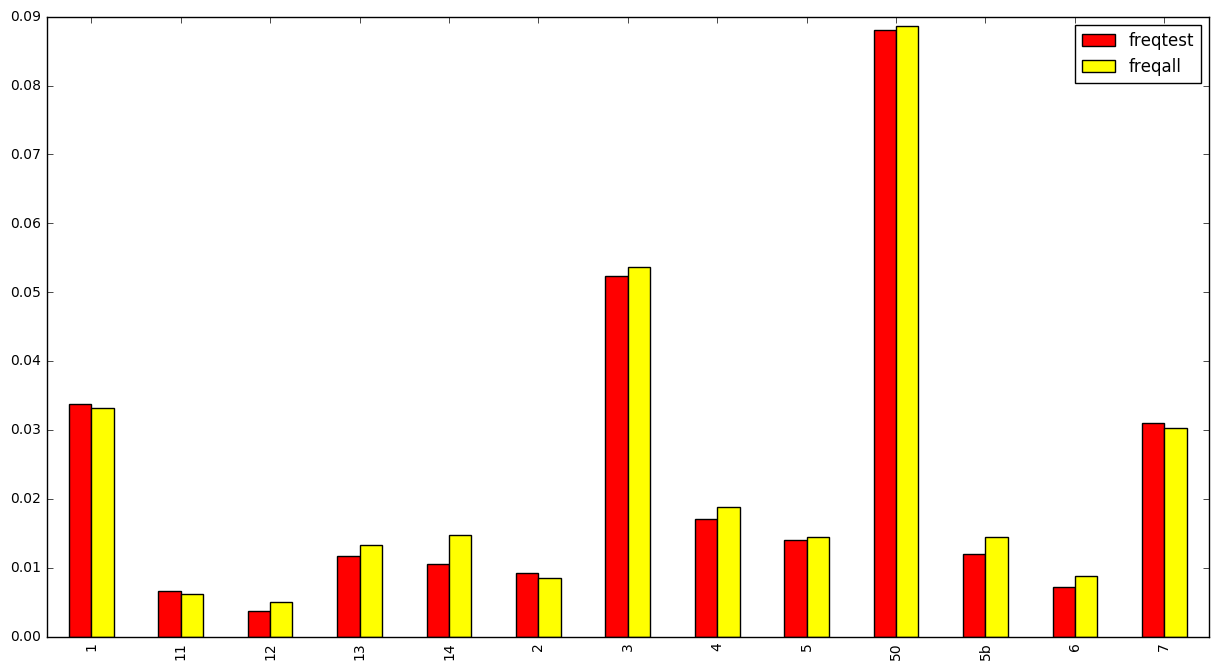

In [30]:
plot_distribution(best_testsplit_causal, regular_codes)

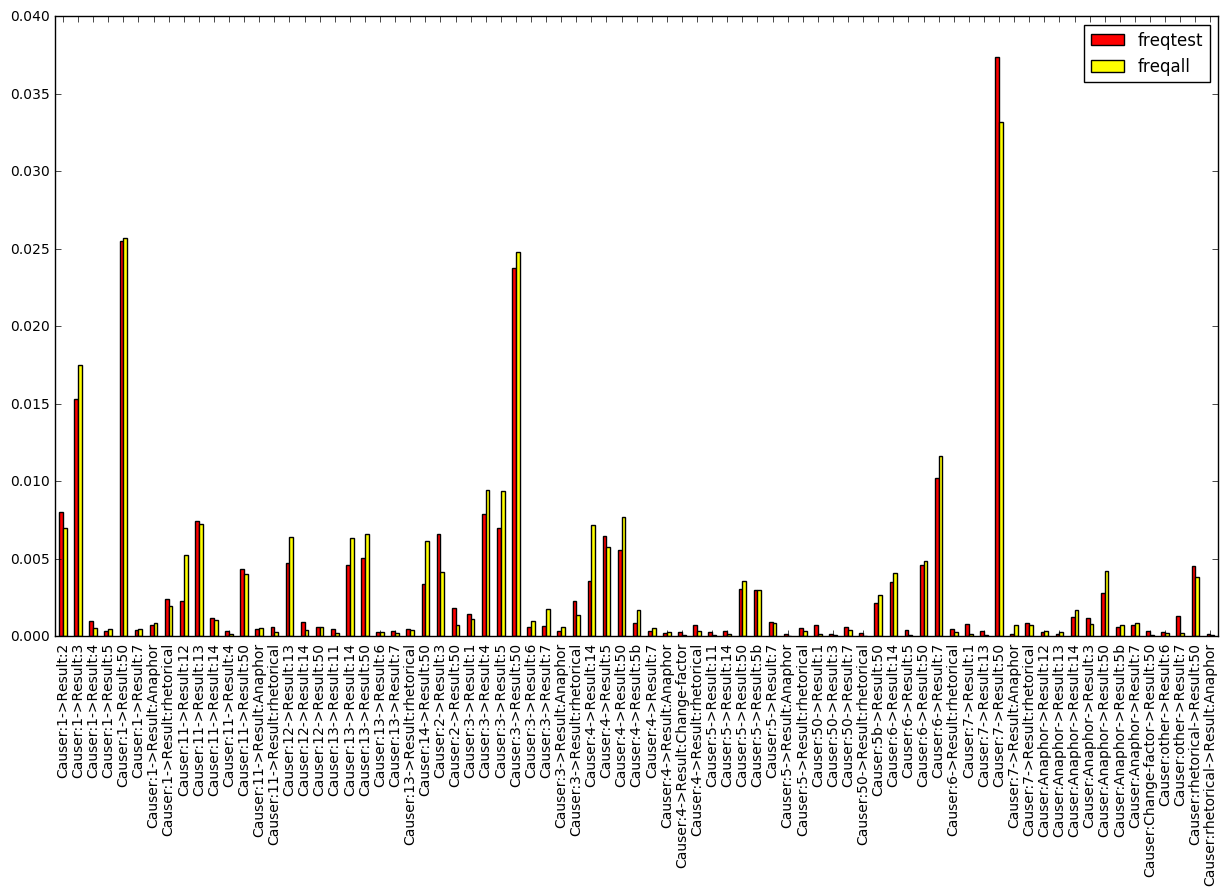

In [31]:
plot_distribution(best_testsplit_causal, causal_codes)

## Move The Files

In [32]:
import shutil

def copy_file(from_file, to_dir):
    to_file = os.path.join(to_dir, os.path.basename(from_file))
    if os.path.exists(to_file):
        print "File already exists: %s deleting" % to_file
        os.remove(to_file)
        shutil.copyfile(from_file, to_file)                    
    else:
        shutil.copyfile(from_file, to_file)

def copy_files(essays, to_dir):
    cnt = 0
    
    # Delete destination folder first
    if os.path.exists(to_dir):
        shutil.rmtree(to_dir, ignore_errors=True)
        
    os.mkdir(to_dir)
    
    ann_files = [e.full_path for e in essays]
    pairs = [joined[get_prefix(f)] for f in ann_files]
    
    for ann, txt in pairs:
        for a in ann:
            copy_file(a, to_dir)
        for t in txt:
            copy_file(t, to_dir)
        cnt += 2
             
    print "Moved %s files" % str(cnt)

In [33]:
# copy_files(essays, all_folder)

Moved 2256 files


In [34]:
# train, test = best_split_causal
# copy_files(train, training_folder)
# copy_files(test,  test_folder)

Moved 1804 files
Moved 452 files


In [35]:
452/2, n_test

(226, 226)

In [36]:
436/2, n_test

(218, 226)